# Data exploration

In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

from cataclop.core.models import *

from cataclop.ml.preprocessing import append_hist, model_to_dict

import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [2]:
hippos = Hippodrome.objects.all()
hippos = [ model_to_dict(hippo) for hippo in hippos ]
hippos_df = pd.DataFrame.from_records(hippos, index="id")
hippos_df.index.name = "hippodrome_id"

for c in ["country"]:
    hippos_df[c] = hippos_df[c].astype("category")

In [12]:
hippos_df[hippos_df['name']=='VINCENNES']

,imported_at,code,name,country
hippodrome_id,,,,
17,2018-05-29 01:16:44.594894,VIN,VINCENNES,FRA


### Hippodromes / country

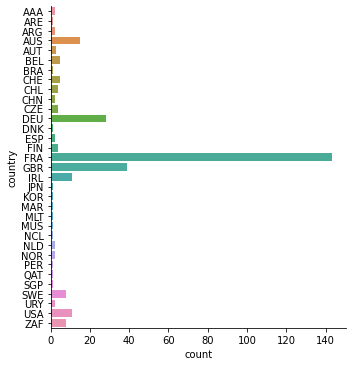

In [3]:
sns.catplot(y="country", kind="count", data=hippos_df)

In [4]:
races = Race.objects.all().prefetch_related("player_set", "session")

sessions = [race.session for race in races]
sessions = list( map(lambda s: model_to_dict(s), set(sessions)) )

sessions_df = pd.DataFrame.from_records(sessions, index="id")
sessions_df.index.name = "session_id"
sessions_df = sessions_df.join(hippos_df, on="hippodrome_id", lsuffix="_session", rsuffix="_hippo")

players = [ model_to_dict(p) for race in races for p in race.player_set.all() ]

races = [ model_to_dict(race) for race in races ]
races_df = pd.DataFrame.from_records(races, index="id")
races_df.index.name = "race_id"
races_df["start_at"] = pd.to_datetime(races_df["start_at"])

races_df = races_df.join(sessions_df, on="session_id", lsuffix="_race", rsuffix="_session")
races_df["date"] = pd.to_datetime(races_df["date"])

for c in ["category", "condition_age", "condition_sex", "sub_category"]:
    races_df[c] = races_df[c].astype("category")

In [5]:
races_df.columns

Index(['imported_at', 'start_at', 'num_race', 'num_bis', 'category',
       'sub_category', 'condition_age', 'condition_sex', 'prize', 'distance',
       'declared_player_count', 'session_id', 'imported_at_session',
       'num_session', 'date', 'hippodrome_id', 'imported_at_hippo', 'code',
       'name', 'country'],
      dtype='object')

### Races / country

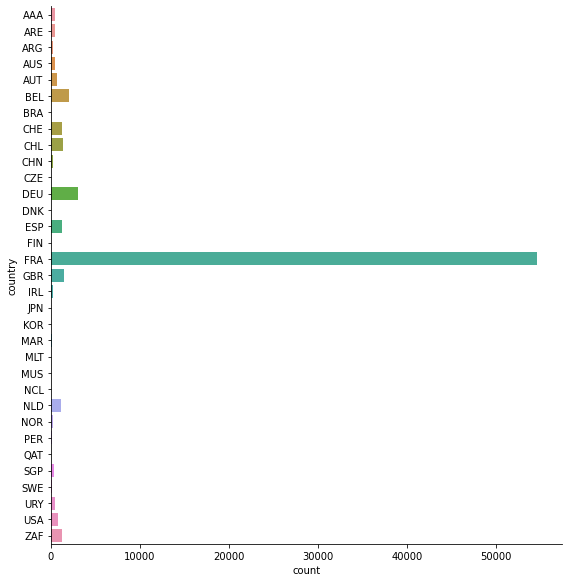

In [17]:
sns.catplot(y="country", kind="count", data=races_df, height=8)

### Races / type

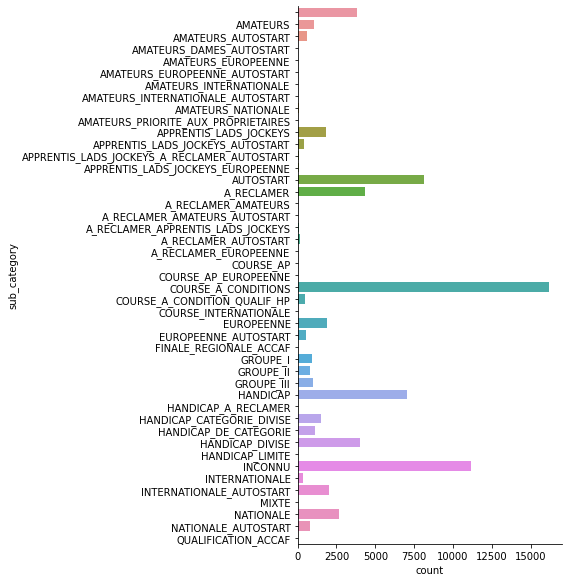

In [13]:
sns.catplot(y="sub_category", kind="count", data=races_df, height=8)

### Evolution of #races for main categories

In [ ]:
for cat in list(races_df['sub_category'].value_counts().index[0:5]):
    r = races_df[races_df['sub_category']==cat].sort_values(by='start_at', ascending=True)
    r['one'] = 1
    r['races_before'] = r['one'].cumsum()
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.set_title(cat)
    ax.plot_date(r['start_at'], r['races_before'])
    plt.show()

### Prize log distribution

In [ ]:
sns.distplot(np.log(races_df['prize']+1))

### #runner distribution

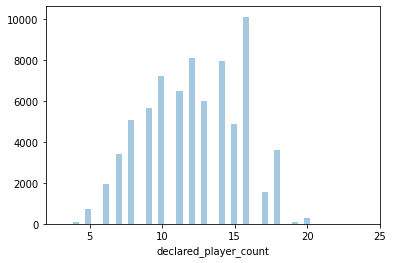

In [18]:
sns.distplot(races_df['declared_player_count'], kde=False)

### Races / hippodromes

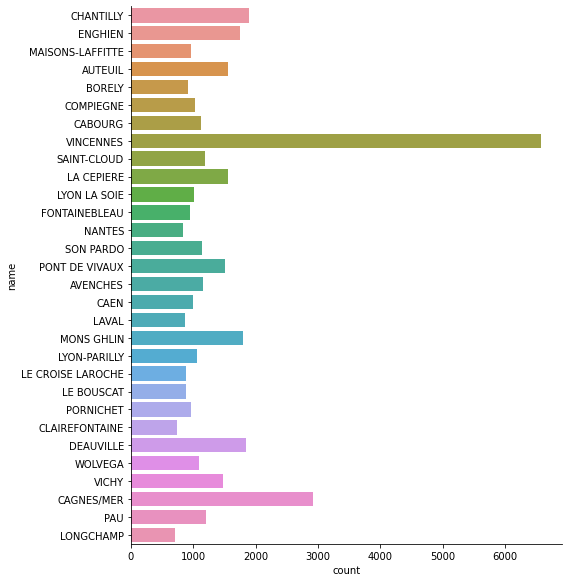

In [8]:
main_hippos = list(races_df['name'].value_counts()[0:30].index)
sns.catplot(y="name", kind="count", data=races_df[(races_df['name'].isin(main_hippos))], height=8)

In [ ]:
df = pd.DataFrame.from_records(players, index="id")
df = df.join(races_df, on="race_id", lsuffix="_player", rsuffix="_race")


In [ ]:
df['winner_dividend'] /= 100.
df[df['position']==1][['winner_dividend', 'final_odds_unibet', 'final_odds_ref', 'final_odds_ref_unibet']].describe()

In [ ]:
df['final_odds_log'] = np.log(df['final_odds'])
sns.relplot(x="final_odds_log", y="position", kind="line", data=df[df['final_odds']<30])

In [ ]:
df['final_odds_unibet_log'] = np.log(df['final_odds_unibet'])
sns.relplot(x="final_odds_unibet_log", y="position", kind="line", data=df[df['final_odds_unibet']<30])

In [ ]:
from django.db.models import Avg, Count, Sum, Q, Max
print(Odds.objects.filter(is_final=True).aggregate(Avg('value')))
print(Odds.objects.filter(is_final_ref=True).aggregate(Avg('value')))

### winning amount / category

In [ ]:
dividend_per_cat = list(Player.objects.filter(winner_dividend__isnull=False)\
     .values('race__sub_category')\
     .annotate(dividend=Avg('winner_dividend'))\
     .order_by('-dividend'))
df = pd.DataFrame.from_records(dividend_per_cat)

sns.catplot(y="race__sub_category", x="dividend", kind="bar", data=df, height=8)

In [ ]:
dividend_per_cat = list(Player.objects.filter(winner_dividend__isnull=False)\
     .values('race__category')\
     .annotate(dividend=Avg('winner_dividend'))\
     .order_by('-dividend'))
df = pd.DataFrame.from_records(dividend_per_cat)

sns.catplot(y="race__category", x="dividend", kind="bar", data=df, height=8)

In [ ]:
from datetime import datetime, timedelta

after = datetime.strptime('2019-01-01', '%Y-%m-%d')

race = Race.objects.filter(imported_at__gt=after).order_by('?').first()

print(race, race.sub_category)

print(race.player_set.aggregate(dividend=Max('winner_dividend'))['dividend']/100.0)
for p in race.player_set.order_by('position'):
    print(p, p.music, p.position, p.post_position, p.winner_dividend)
    print([(o.date.strftime('%H:%M:%S'), o.value, o.evolution, o.offline) for o in p.odds_set.filter(is_final=False).order_by('date')])

### min/max odds, # of player and winning amount relation

In [ ]:
races = Race.objects\
  .annotate(winner_dividend=Max('player__winner_dividend'), \
            max_odds=Max('player__final_odds'), \
            min_odds=Min('player__final_odds'), \
            player_count=Count('player__id')) \
  .values('winner_dividend', 'min_odds', 'max_odds', 'player_count')

df = pd.DataFrame.from_records(list(races))
df = df+1.
df = np.log(df)
g = sns.pairplot(df)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6)
